# Goods Shipment Duration prediction and Estimating Late Delivery Risk

Goods Late delivery risk identification by predicting fastest and normal Shipping Durations.

The Machine Learning model built here will enable delivery industries to identify the 'risk of late delivery' and predict the fastest and normal duration of goods shipment for the clients/ customers/buyers.


### Goals

- predict the estimated and real shippment times
- use the predicted values to asses the late delivery
- introduce ML Pipelines
- introduce Neural Networks

Ref: https://www.kaggle.com/code/sukanthen/e-commerce-multi-output-models-project-cse07/notebook

Data Source: https://data.mendeley.com/datasets/8gx2fvg2k6/5

Data Visualization: https://public.tableau.com/app/profile/rahman.firmansyah/viz/DataCoSmartSupplyChain-Dashboard/dashboard-1

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score,r2_score,mean_absolute_error,mean_squared_error,accuracy_score,classification_report,confusion_matrix

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

## Read and inspect data

In [ ]:
original_data = pd.read_csv('DataCoSupplyChainDataset.csv', header= 0, encoding='unicode_escape')
original_data.head()

```
FIELDS	DESCRIPTION
Type	: Type of transaction made
Days for shipping (real)	: Actual shipping days of the purchased product
Days for shipment (scheduled)	: Days of scheduled delivery of the purchased product
Benefit per order	: Earnings per order placed
Sales per customer	: Total sales per customer made per customer
Delivery Status	: Delivery status of orders: Advance shipping , Late delivery , Shipping canceled , Shipping on time
Late_delivery_risk	: Categorical variable that indicates if sending is late (1), it is not late (0).
Category Id	: Product category code
Category Name	: Description of the product category
Customer City	: City where the customer made the purchase
Customer Country	: Country where the customer made the purchase
Customer Email	: Customer's email
Customer Fname	: Customer name
Customer Id	: Customer ID
Customer Lname	: Customer lastname
Customer Password	: Masked customer key
Customer Segment	: Types of Customers: Consumer , Corporate , Home Office
Customer State	: State to which the store where the purchase is registered belongs
Customer Street	: Street to which the store where the purchase is registered belongs
Customer Zipcode	: Customer Zipcode
Department Id	: Department code of store
Department Name	: Department name of store
Latitude	: Latitude corresponding to location of store
Longitude	: Longitude corresponding to location of store
Market	: Market to where the order is delivered : Africa , Europe , LATAM , Pacific Asia , USCA
Order City	: Destination city of the order
Order Country	: Destination country of the order
Order Customer Id	: Customer order code
order date (DateOrders)	: Date on which the order is made
Order Id	: Order code
Order Item Cardprod Id	: Product code generated through the RFID reader
Order Item Discount	: Order item discount value
Order Item Discount Rate	: Order item discount percentage
Order Item Id	: Order item code
Order Item Product Price	: Price of products without discount
Order Item Profit Ratio	: Order Item Profit Ratio
Order Item Quantity	: Number of products per order
Sales	: Value in sales
Order Item Total	: Total amount per order
Order Profit Per Order	: Order Profit Per Order
Order Region	: Region of the world where the order is delivered : Southeast Asia ,South Asia ,Oceania ,Eastern Asia, West Asia , West of USA , US Center , West Africa, Central Africa ,North Africa ,Western Europe ,Northern , Caribbean , South America ,East Africa ,Southern Europe , East of USA ,Canada ,Southern Africa , Central Asia , Europe , Central America, Eastern Europe , South of USA
Order State	: State of the region where the order is delivered
Order Status	: Order Status : COMPLETE , PENDING , CLOSED , PENDING_PAYMENT ,CANCELED , PROCESSING ,SUSPECTED_FRAUD ,ON_HOLD ,PAYMENT_REVIEW
Product Card Id	: Product code
Product Category Id	: Product category code
Product Description	: Product Description
Product Image	: Link of visit and purchase of the product
Product Name	: Product Name
Product Price	: Product Price
Product Status	: Status of the product stock :If it is 1 not available , 0 the product is available
Shipping date (DateOrders)	: Exact date and time of shipment
Shipping Mode	: The following shipping modes are presented : Standard Class , First Class , Second Class , Same Day
```

In [ ]:
original_data = original_data.sort_values(by='order date (DateOrders)')

In [ ]:
print('1) Number of columns are : ',original_data.shape[1])
print('2) Number of rows are : ',original_data.shape[0])
print('3) Total number of data-points :',original_data.size)
numerical_features = [f for f in original_data.columns if original_data[f].dtypes!='O']
print('4) Count of Numerical Features :',len(numerical_features))
cat_features = [c for c in original_data.columns if original_data[c].dtypes=='O']
print('5) Count of Categorical Features :',len(cat_features))

In [ ]:
x = original_data.isnull().sum().sum()/(original_data.shape[0]*original_data.shape[1])*100
print('Percentage of Total Missing Values is ' ,round(x,2) ,'%')
print('Missing Value Estimation :')
for i in original_data.columns:
    if original_data[i].isna().sum() > 0:
        print(f'Feature {i} has {original_data[i].isna().sum()} missing values')

## Feature Selection

- many features exist, better features may have been left out
- derived features to be added: distance between source and destination etc

In [ ]:
sns.set()
sns.set(rc={'figure.figsize':(16, 8)})
sns.scatterplot(x="Days for shipment (scheduled)",y="Days for shipping (real)",hue="Late_delivery_risk",data=original_data)

In [ ]:
corrmap = original_data.corr()
top=corrmap.index
plt.figure(figsize=(30,20))
g=sns.heatmap(original_data[top].corr(),annot=True,cmap="RdYlGn")

#### Insights from Heatmap:

1. Columns that are similar with same values but with different metadata (duplicate columns)
    - [Benefit per order], Order Profit per order
    - [Sales per customer], Sales, Order Item Total
    - [Category ID], Product Category ID, Order Customer ID, Order Item Category ID, Product card ID,
    - [Order Item Product Price],Product Price

2. Unwanted features(null or less correlated values)
    - Product Description
    - Product Status

In [ ]:
# 'Days for shipping (real)','Days for shipment (scheduled)', 'Late_delivery_risk', 'Order Status', 'Delivery Status',
selected_features = ['Benefit per order', 'Sales per customer', 'Latitude', 'Longitude']
categorical_features = ['Type', 'Shipping Mode', 'Order Region', 'Order Country', 'Order City', 'Market']

### Machine Learning Pipelines

- organize the processing 
- make it repeatable
- allow persisting the model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import make_column_transformer

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    original_data, 
    original_data[['Days for shipping (real)', 'Days for shipment (scheduled)', 'Late_delivery_risk']], 
    test_size = 0.20, 
    shuffle = False
)

y_train_risk = y_train.pop('Late_delivery_risk')
y_test_risk = y_test.pop('Late_delivery_risk')

In [ ]:
class DateExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(Self, X, y = None):
        return pd.concat([X.apply(lambda x: pd.DatetimeIndex(x).year, axis=0), 
               X.apply(lambda x: pd.DatetimeIndex(x).month, axis=0), 
               X.apply(lambda x: pd.DatetimeIndex(x).day, axis=0)], 
                axis=1) 

In [ ]:
%%time

preprocessor = ColumnTransformer(
    transformers=[
        ("date_extractor", DateExtractor(), ['order date (DateOrders)', 'shipping date (DateOrders)']),
        ("categorical_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
        ("column_selector", "passthrough", selected_features)
    ],
    remainder="drop"
)

data_model = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

set_config(display="diagram")
display(data_model)

transformed_data = data_model.fit_transform(x_train)

In [ ]:
raw_features = ['order date (DateOrders)', 'shipping date (DateOrders)', 'Type', 'Shipping Mode', 'Order Region', 'Order Country', 'Order City', 'Market', 
                     'Benefit per order', 'Sales per customer', 'Latitude','Longitude']

display(x_train[raw_features].head())
display(pd.DataFrame(transformed_data).head())

### OLS

In [ ]:
def model_scores(y_true, y_pred):
    a = r2_score(y_true, y_pred)
    b = mean_squared_error(y_true, y_pred)
    c = mean_absolute_error(y_true, y_pred)
    print(f'The r-squared score of the model is {a}')
    print(f'The mean squared error is {b}')
    print(f'The mean accuracy score is {c}')

In [ ]:
%%time

pipeline_model_ols = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', MultiOutputRegressor(LinearRegression()))
    ])

set_config(display="diagram")
display(pipeline_model_ols)

pipeline_model_ols = pipeline_model_ols.fit(x_train, y_train)

In [ ]:
%%time
# predicts using the pipeline which guarantees the same data, in the same order and in the same format
# guarantees that ordinals are encoded in the same way
predictions_ols = pipeline_model_ols.predict(x_test)
predictions_ols_df = pd.DataFrame(predictions_ols, columns=['real_shipment', 'schedule_shipment'])
predictions_ols_df.head()

In [ ]:
model_scores(y_test, predictions_ols)

### XGB

In [ ]:
%%time

pipeline_model_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', MultiOutputRegressor(xgb.XGBRegressor()))
    ])

pipeline_model_xgb = pipeline_model_xgb.fit(x_train, y_train)

In [ ]:
%%time

predictions_xgb = pipeline_model_xgb.predict(x_test)
predictions_xgb_df = pd.DataFrame(predictions_xgb, columns=['real_shipment', 'schedule_shipment'])
predictions_xgb_df.head()

In [ ]:
model_scores(y_test, predictions_xgb)

## Neural Networks

https://www.ibm.com/cloud/learn/neural-networks

- Artifical Neural Network (ANN)
- Fully Connected Neural Nework
- Deep Neural Network
- Recurrent Neural Network (RNN)
- Convolutional Neural Network (CNN)

### Usage
- unstructured data (text & image recognition)
- classification mainly
- XoR problem

#### Perceptron

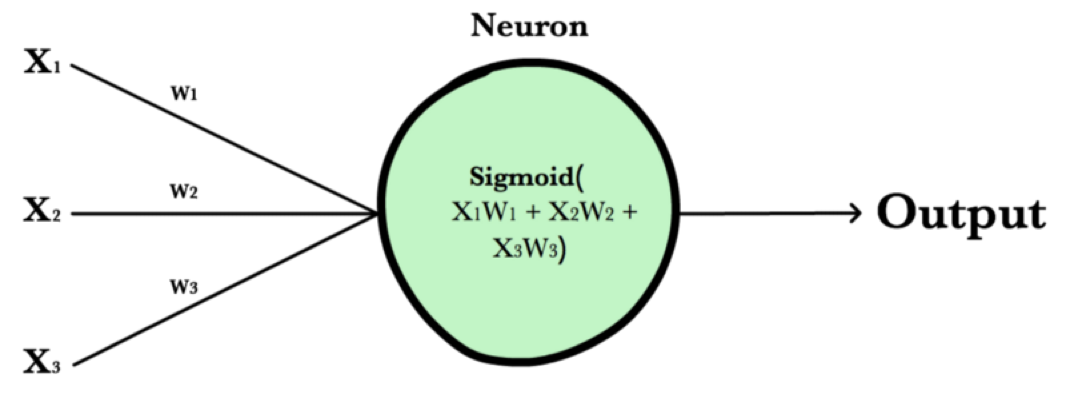

#### Activation Functions 

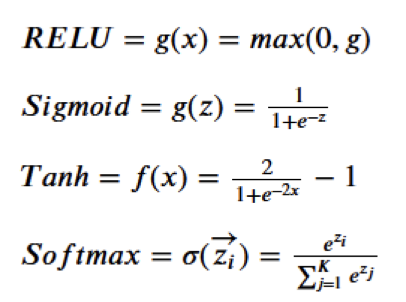

### NN Architecture

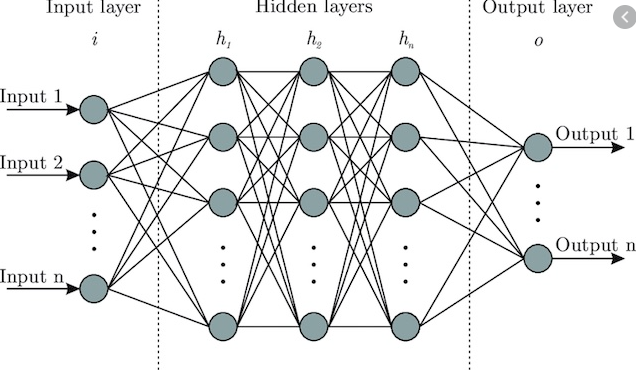

#### Hidden Layers
- what are the hidden layers?
- how manny hidden layers?
- how many nodes in the hidden layers?
- how to interpret the weights?

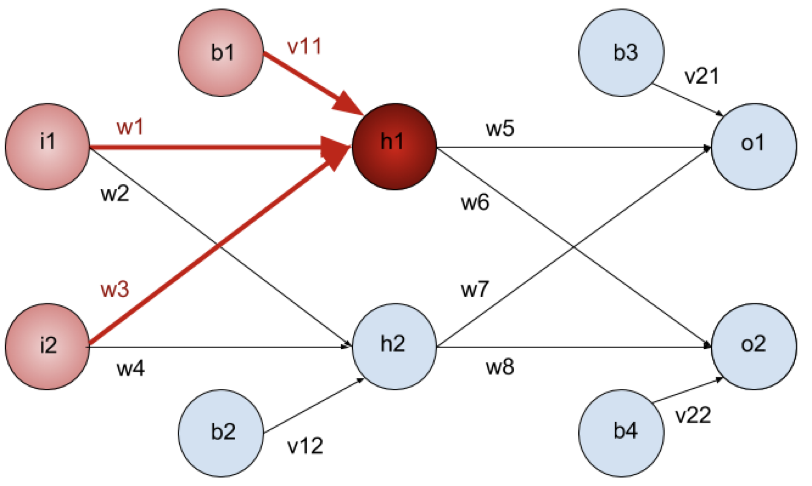

### Training
- **Forward propagation** - Feed the network left to right from input, obtain the output and compute the cost function
- **Back propagation** – From right to left compute the partial derivatives of the cost function update the weights

#### Cost function

Generalization of logistic regression cost function.

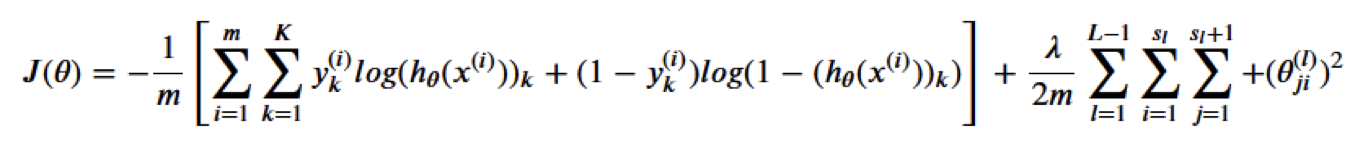

### Pros and cons

- maps very well non linear relationships
- long time to train
- non intuitive network design
- difficult to explain
- black box

https://www.linkedin.com/pulse/artificial-neural-networks-advantages-disadvantages-maad-m-mijwel/

**A neural network is the second best way to solve any problem. The best way is to actually understand the problem. - Internet**

In [ ]:
use_defaults = True

In [ ]:
%%time

# Train a neural network model for targets 'Days for shipping (real)' and 'Days for shipment (scheduled)'
from sklearn.neural_network import MLPRegressor

if use_defaults:
    estimator = MLPRegressor(activation='relu', solver='adam', verbose=True)
else:
    estimator = MLPRegressor(activation='relu', 
                              solver='adam', 
                              n_iter_no_change=30,
                              hidden_layer_sizes=(20, 20), 
                              max_iter=1000, 
                              random_state=42,
                              verbose=True)

pipeline_model_nn = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])

pipeline_model_nn = pipeline_model_nn.fit(x_train, y_train)

In [ ]:
#save the model to be used later
#import joblib
#joblib.dump(pipeline_model_nn, 'mlp_regressor_20_20.pkl')

In [ ]:
# load a good, pretrained model
#import joblib
#pipeline_model_nn = joblib.load('mlp_regressor_20_20.pkl')

In [ ]:
%%time

predictions_nn = pipeline_model_nn.predict(x_test)
predictions_nn_df = pd.DataFrame(predictions_nn, columns=['real_shipment','schedule_shipment'])
predictions_nn_df.head()

In [ ]:
model_scores(y_test, predictions_nn)

### Compute Risk

In [ ]:
predictions_xgb_df['Late_delivery_risk'] = np.where(predictions_xgb_df['real_shipment'] > predictions_xgb_df['schedule_shipment'], 1, 0)
predictions_ols_df['Late_delivery_risk'] = np.where(predictions_ols_df['real_shipment'] > predictions_ols_df['schedule_shipment'], 1, 0)
predictions_nn_df['Late_delivery_risk'] = np.where(predictions_nn_df['real_shipment'] > predictions_nn_df['schedule_shipment'], 1, 0)

In [ ]:
def risk_scores(y_true, y_pred, title):
    print('1) Accuracy:', accuracy_score(y_true, y_pred))
    print('2) AUROC:', roc_auc_score(y_true, y_pred))
    print('3) Classification metrics:')
    print(classification_report(y_true, y_pred))
    
    ax=plt.subplot()
    sns.heatmap(confusion_matrix(y_true, y_pred),annot=True, ax=ax, fmt='d');
    
    ax.set_xlabel('Predicted'); 
    ax.set_ylabel('Actual')
    ax.set_title(title);

In [ ]:
def plot_risk(df_arr):
    out_df = pd.concat(df_arr)
    sns.countplot(x="Late_delivery_risk", hue='source', data=out_df).set_title('Late delivery risks')

In [ ]:
risk_scores(y_test_risk, predictions_ols_df['Late_delivery_risk'], 'OLS')

In [ ]:
risk_scores(y_test_risk, predictions_xgb_df['Late_delivery_risk'], 'XGB')

In [ ]:
risk_scores(y_test_risk, predictions_nn_df['Late_delivery_risk'], 'NN')

In [ ]:
y_true = pd.DataFrame(y_test_risk, columns=['Late_delivery_risk'])

y_true['source'] = 'real'
predictions_ols_df['source'] = 'ols'
predictions_xgb_df['source'] = 'xgb'
predictions_nn_df['source'] = 'NN'

plot_risk([y_true, predictions_ols_df, predictions_xgb_df, predictions_nn_df])

## HPO

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

```
class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)[source]
 ```

## Summary

- training and scoring (predictions) are separate processes, occuring at separate times in separate locations
- pipelines help operationalize the ML process
- NN are powerful but expensive to train and tune